In [3]:
import sys
sys.path.append('../')

from model import DecisionTree
from rule import RuleExtractor
import matplotlib.pyplot as plt

import os
import numpy as np
import warnings
import pandas as pd

np.set_printoptions(suppress=True)

warnings.filterwarnings(action='ignore')

In [4]:
# sage, srgnn 중 선택
embed_model = 'srgnn'
filename = {'sage' : 'user_embedding_sage_sid_6to6_weighted.npy', 'srgnn' : 'srgnn_user_hybrid_6to6_weighted.npy'}
data_path = "../data/"

pivot_df = pd.read_csv(os.path.join(data_path, 'pivot_genre2_data.csv'), index_col=0)
embedding = np.load(os.path.join(data_path, filename[embed_model]))

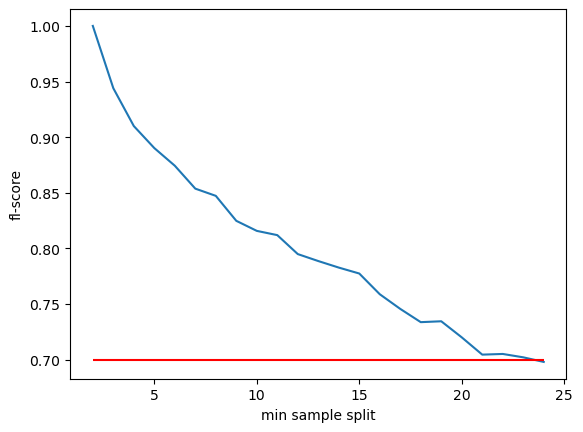

23 0.7020386552303569


In [5]:
model = DecisionTree(pivot_df, embedding)
proper_mss, max_score = model.get_proper_min_sample_split(target_score=0.7, scoring='precision')
print(proper_mss, max_score)

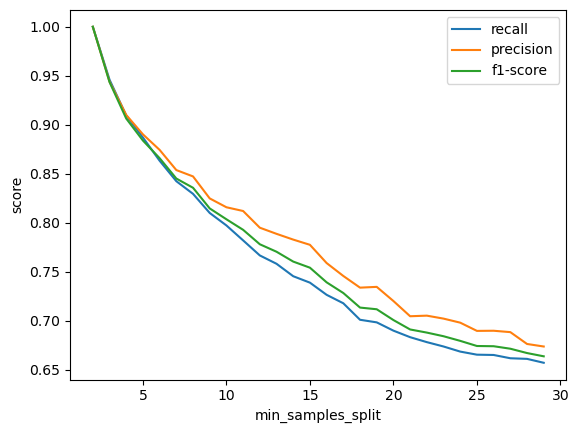

In [6]:
model = DecisionTree(pivot_df, embedding)
passed_mss, score_list, depth_list = model.get_all_split(scoring='all')

r_list = []
p_list = []
f_list = []

for score in score_list:
    r_list.append(score[0]) 
    p_list.append(score[1])
    f_list.append(score[2])

plt.plot(passed_mss, r_list, label='recall')
plt.plot(passed_mss, p_list, label='precision')
plt.plot(passed_mss, f_list, label='f1-score')

plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.legend()

plt.show()

In [7]:
f_list

[1.0,
 0.9435690328262574,
 0.9063253311451365,
 0.8838411989082575,
 0.8658346639203685,
 0.8450528144397246,
 0.8356279927200064,
 0.8145371741121079,
 0.8034519903709256,
 0.7926840771728869,
 0.777949353355897,
 0.7703183350473144,
 0.7602670320658914,
 0.754034405139944,
 0.7390829615459905,
 0.7281598870721806,
 0.7133047371710362,
 0.7115910966271841,
 0.7005657036957811,
 0.6909553620276018,
 0.6877653358569772,
 0.6840526239245955,
 0.6793216125989587,
 0.6740800812026335,
 0.6738516738172182,
 0.6713062854018989,
 0.6668799634324754,
 0.6635463899375024]

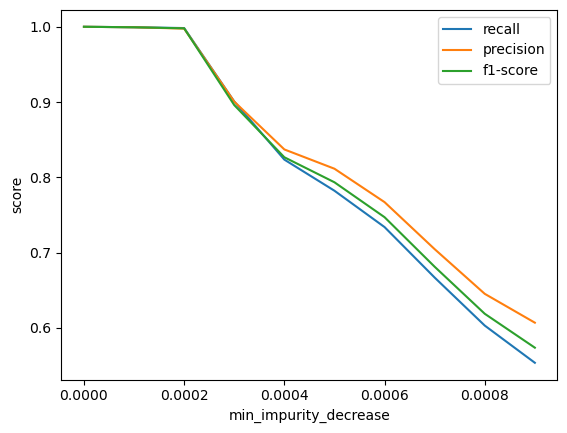

In [4]:
model = DecisionTree(pivot_df, embedding)
passed_mss, score_list, depth_list = model.get_all_impurity(scoring='all')

r_list = []
p_list = []
f_list = []

for score in score_list:
    r_list.append(score[0]) 
    p_list.append(score[1])
    f_list.append(score[2])

plt.plot(passed_mss, r_list, label='recall')
plt.plot(passed_mss, p_list, label='precision')
plt.plot(passed_mss, f_list, label='f1-score')

plt.xlabel('min_impurity_decrease')
plt.ylabel('score')
plt.legend()

plt.show()

In [7]:
passed_mss[13], f_list[13]

(15, 0.6043143289516867)

In [8]:
model = DecisionTree(pivot_df, embedding)
model.max_depth_dt = model.make_dt(max_depth=9, min_samples_split=15)

k=15
seg_dic = {}
len_or_list = []
save_dir = f'../output/{embed_model}_rule'

for i in range(k):
    rule_extractor = RuleExtractor(model)
    rules = rule_extractor.extract_rule(segment_num=i)
    
    or_list = rules.split('[OR]')

    ls = [[r.split() for r in l.split('[AND]')] for l in or_list]
    new_ls = []
    for node in ls:
        new_ls.append([])
        rule_dic = {}
        for r in node:
            key_name = f'{r[0]} {r[1]} '
            rule_dic[key_name] = rule_dic.get(key_name, [])
            rule_dic[key_name].append(float(r[2]))    
        
        for k, v in rule_dic.items():
            if k in '>':
                rule_dic[k] = max(v)
            else:
                rule_dic[k] = min(v)
        
        for k, v in rule_dic.items():
            new_rule = k.split()
            new_rule.append(str(v))
            new_ls[-1].append(new_rule)
            
    # 생성 규칙 수
    total_rule_ls = []
    for node in new_ls:
        for rule in node:
            total_rule_ls.append(str(rule))
    
    node_list = []
    for node in new_ls:
        rule_list = []
        for rule in node:
            rule_list.append(''.join(rule))
        node_rule = ' [AND] '.join(rule_list)
        node_list.append(node_rule)
    total_rule = ' [OR]\n'.join(node_list)

    with open(save_dir + f'/{embed_model}_seg_rule_extract{i}.txt', 'w') as f:
        f.writelines(total_rule)